# Сборный проект 2

## Введение

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Существует две задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [90]:
!pip install -q phik


In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)
from sklearn.svm import SVC
matplotlib_axes_logger.setLevel('ERROR')
RANDOM_STATE = 42
TEST_SIZE = 0.25
sns.set()

In [49]:
df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
display(df_train_job_satisfaction_rate.head(5))
df_train_job_satisfaction_rate.info()

df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
display(df_test_features.head(5))
df_test_features.info()

df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
display(df_test_target_job_satisfaction_rate.head(5))
df_test_target_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


### Предобработка данных

Произведена проверка на дубликаты по столбцу id для всех трех датафреймов - дубликатов нет

In [50]:
print(f'Количество дубликтов: df_train_job_satisfaction_rate: {df_train_job_satisfaction_rate.duplicated(subset="id").sum()},'
      f'df_test_features: {df_test_features.duplicated(subset="id").sum()},'
      f'df_test_target_job_satisfaction_rate: {df_test_target_job_satisfaction_rate.duplicated(subset="id").sum()}')


Количество дубликтов: df_train_job_satisfaction_rate: 0,df_test_features: 0,df_test_target_job_satisfaction_rate: 0


В датафреймах df_train_job_satisfaction_rate и df_test_features обнаружены NULL значения для колонок:
- dept
- level

Так как это категориальные переменные, то сначала надо произвести вывод всех значений которе принимает каждый параметр

In [51]:
display(df_train_job_satisfaction_rate['dept'].value_counts(dropna = False))
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))
display(df_train_job_satisfaction_rate['workload'].value_counts())

display(df_test_features['dept'].value_counts(dropna = False))
display(df_test_features['level'].value_counts(dropna = False))

display(df_test_features['workload'].value_counts())


sales         1512
technology    866 
purchasing    610 
marketing     550 
hr            456 
NaN           6   
Name: dept, dtype: int64

junior    1894
middle    1744
sinior    358 
NaN       4   
Name: level, dtype: int64

medium    2066
low       1200
high      734 
Name: workload, dtype: int64

sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN           2  
              1  
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
NaN       1  
Name: level, dtype: int64

medium    1043
low       593 
high      363 
          1   
Name: workload, dtype: int64

Обнаружена еще одна проблема во входных данных - в колонках df_test_features['dept'], df_test_features['workload'] имеется одно значение с категорией пробел. Очевидно, что это ошибка ввода данных и она в данном случае приравнивается к NaN.
Так как количество строкс с NaN или ' ' для этих параметров крайне мало по сравнению с общим количеством строк и нет явного значения, на которое можно заменить NaN или пробел (так как это категориальные параметры) то я предлагаю строки с NaN и пробелом удалить из этих датафреймов

In [52]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.dropna()
df_train_job_satisfaction_rate.info()

df_test_features = df_test_features.dropna()
df_test_features.info()


df_test_features.drop(df_test_features[df_test_features['dept'] == ' '].index, inplace = True)
df_test_features['dept'].value_counts()

df_test_features.drop(df_test_features[df_test_features['workload'] == ' '].index, inplace = True)
df_test_features['workload'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   object 
 2   level                  3990 non-null   object 
 3   workload               3990 non-null   object 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   object 
 6   last_year_violations   3990 non-null   object 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 342.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----

medium    1040
low       592 
high      363 
Name: workload, dtype: int64

Кроме того, надо провалидировать значения оставшихся кат параметров

In [53]:
display(df_train_job_satisfaction_rate['workload'].value_counts())
display(df_train_job_satisfaction_rate['last_year_promo'].value_counts())
display(df_train_job_satisfaction_rate['last_year_violations'].value_counts())
display(df_test_features['workload'].value_counts())
display(df_test_features['last_year_promo'].value_counts())
display(df_test_features['last_year_violations'].value_counts())



medium    2060
low       1197
high      733 
Name: workload, dtype: int64

no     3870
yes    120 
Name: last_year_promo, dtype: int64

no     3432
yes    558 
Name: last_year_violations, dtype: int64

medium    1040
low       592 
high      363 
Name: workload, dtype: int64

no     1932
yes    63  
Name: last_year_promo, dtype: int64

no     1733
yes    262 
Name: last_year_violations, dtype: int64

С этими значениями все нормально - опечаток и ошибок при вводе нет

В значении 'sinior' для колонки level для датафреймов df_train_job_satisfaction_rate и df_test_features допущена грамматическая ошибка - но она допущена везде, где используется это значение - написано как *sinior*.  Предлагаю везде исправить на *senior*

In [54]:
df_train_job_satisfaction_rate['level'] = df_train_job_satisfaction_rate['level'].replace('sinior', 'senior')
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')
display(df_test_features['level'].value_counts(dropna = False))

junior    1888
middle    1744
senior    358 
Name: level, dtype: int64

junior    971
middle    853
senior    171
Name: level, dtype: int64

Необходимо изменить тип "object" на "string" для всех колонок типа *object*

In [55]:
df_train_job_satisfaction_rate_str_col_list = df_train_job_satisfaction_rate.select_dtypes(exclude=np.number).columns
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list] = \
  df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features_str_col_list = df_test_features.select_dtypes(exclude=np.number).columns
df_test_features[df_test_features_str_col_list] = \
  df_test_features[df_test_features_str_col_list].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   string 
 2   level                  3990 non-null   string 
 3   workload               3990 non-null   string 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   string 
 6   last_year_violations   3990 non-null   string 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), string(5)
memory usage: 342.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

Колонки employment_years и supervisor_evaluation для test и train датафреймов надо перевести в категориальный формат, так как их значения представляют собой целые числа и они занимают отоносительно небольшой диапазон

In [56]:
df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']] = \
  df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features[['employment_years', 'supervisor_evaluation']] = \
  df_test_features[['employment_years', 'supervisor_evaluation']].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   string 
 2   level                  3990 non-null   string 
 3   workload               3990 non-null   string 
 4   employment_years       3990 non-null   string 
 5   last_year_promo        3990 non-null   string 
 6   last_year_violations   3990 non-null   string 
 7   supervisor_evaluation  3990 non-null   string 
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(2), string(7)
memory usage: 342.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

### Исследовательский анализ данных

Построим гистограммы и boxplots для количественных параметров и pie диаграммы для категориальных

,id,salary,job_satisfaction_rate
count,3990.000000,3990.000000,3990.000000
mean,544951.793985,33953.383459,0.533772
std,257889.850721,14907.247698,0.225353
min,100954.000000,12000.000000,0.030000
25%,322834.250000,22800.000000,0.360000
50%,534082.500000,30000.000000,0.560000
75%,771600.000000,43200.000000,0.710000
max,999521.000000,98400.000000,1.000000


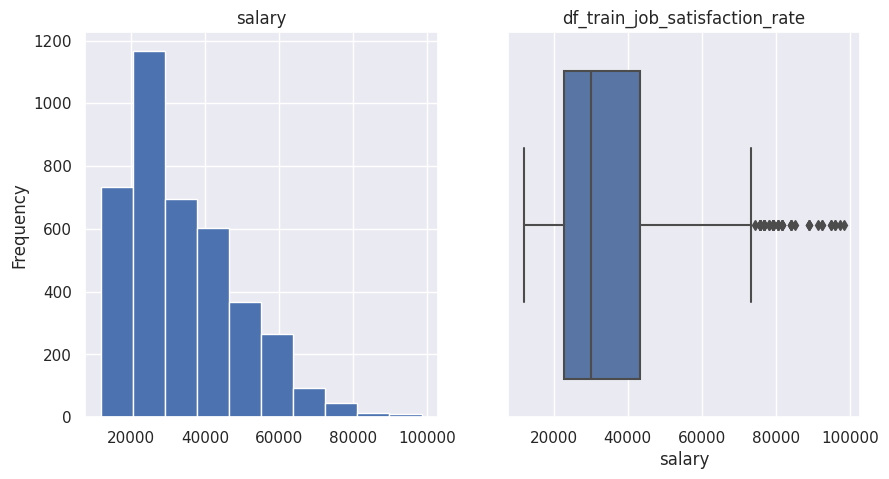

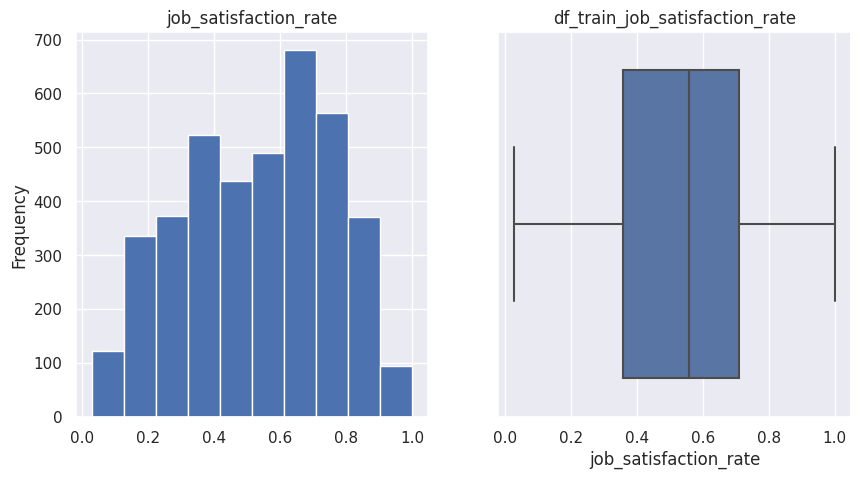

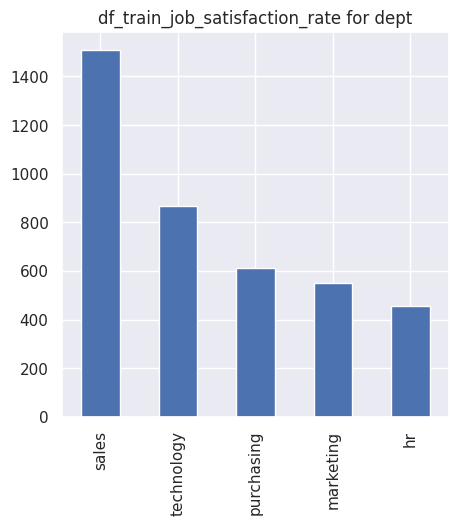

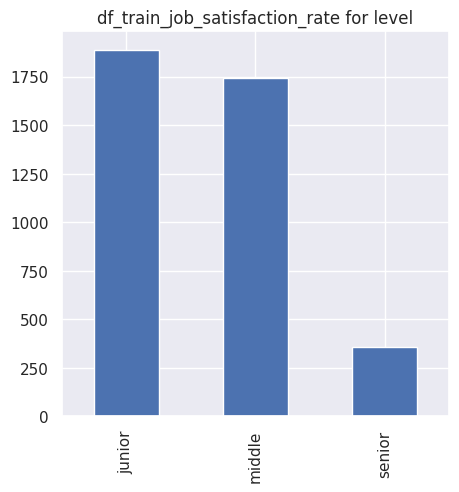

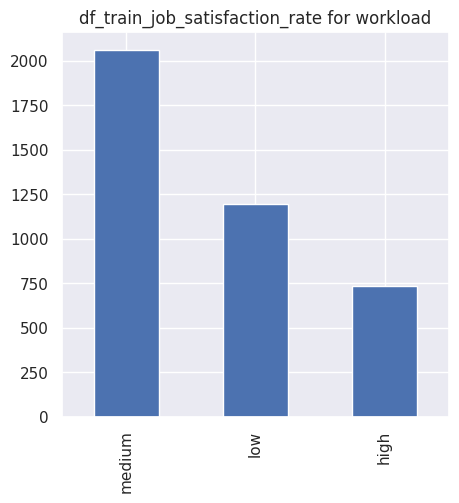

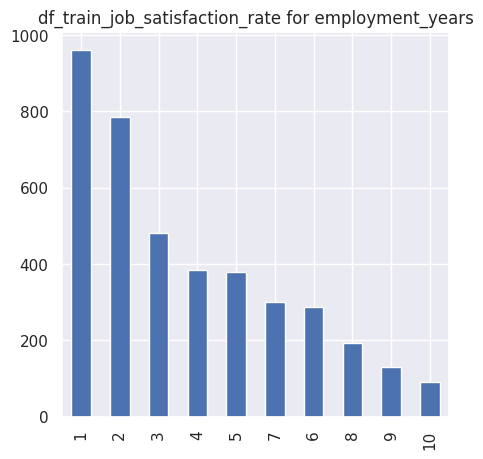

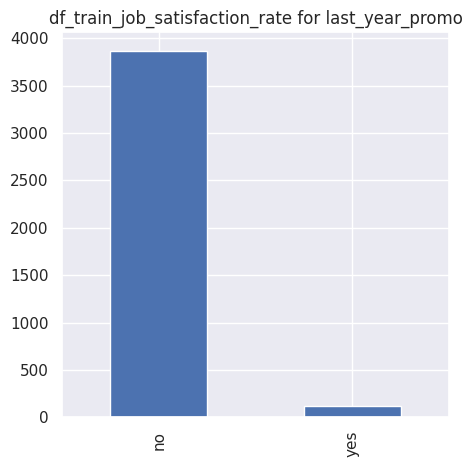

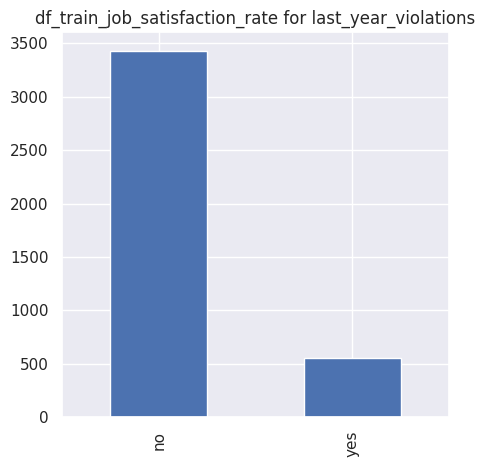

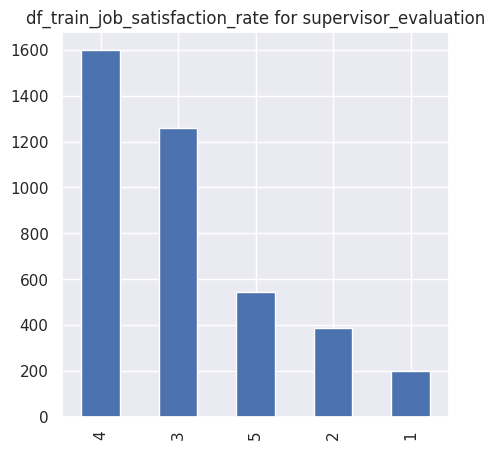

In [57]:
display(df_train_job_satisfaction_rate.describe())

def plot_sub_plot_hist_boxplot(df, title):
    for col in df.columns:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='bar',  label='',  figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

plot_sub_plot_hist_boxplot(df_train_job_satisfaction_rate.select_dtypes(include=np.number), 'df_train_job_satisfaction_rate')
plot_bar_plot_for_columns(df_train_job_satisfaction_rate.select_dtypes(exclude=np.number), 'df_train_job_satisfaction_rate')


Я не вижу явных выбросов для количественных параметров. Распределение целевой переменной job_satisfaction_rate похоже на нормальное, mean ~ median, выбросов нет.

,dept,employment_years,job_satisfaction_rate,last_year_promo,last_year_violations,level,salary,supervisor_evaluation,workload
dept,1.000000,0.035478,0.082037,0.000000,0.000000,0.000000,0.281731,0.104699,0.016556
employment_years,0.035478,1.000000,0.326829,0.183654,0.057655,0.683189,0.483064,0.000000,0.181259
job_satisfaction_rate,0.082037,0.326829,1.000000,0.190921,0.560773,0.080910,0.166577,0.764170,0.056024
last_year_promo,0.000000,0.183654,0.190921,1.000000,0.000000,0.101530,0.214741,0.013619,0.058676
last_year_violations,0.000000,0.057655,0.560773,0.000000,1.000000,0.000000,0.000000,0.182371,0.000000
level,0.000000,0.683189,0.080910,0.101530,0.000000,1.000000,0.717484,0.000000,0.419471
salary,0.281731,0.483064,0.166577,0.214741,0.000000,0.717484,1.000000,0.000000,0.788710
supervisor_evaluation,0.104699,0.000000,0.764170,0.013619,0.182371,0.000000,0.000000,1.000000,0.036178
workload,0.016556,0.181259,0.056024,0.058676,0.000000,0.419471,0.788710,0.036178,1.000000


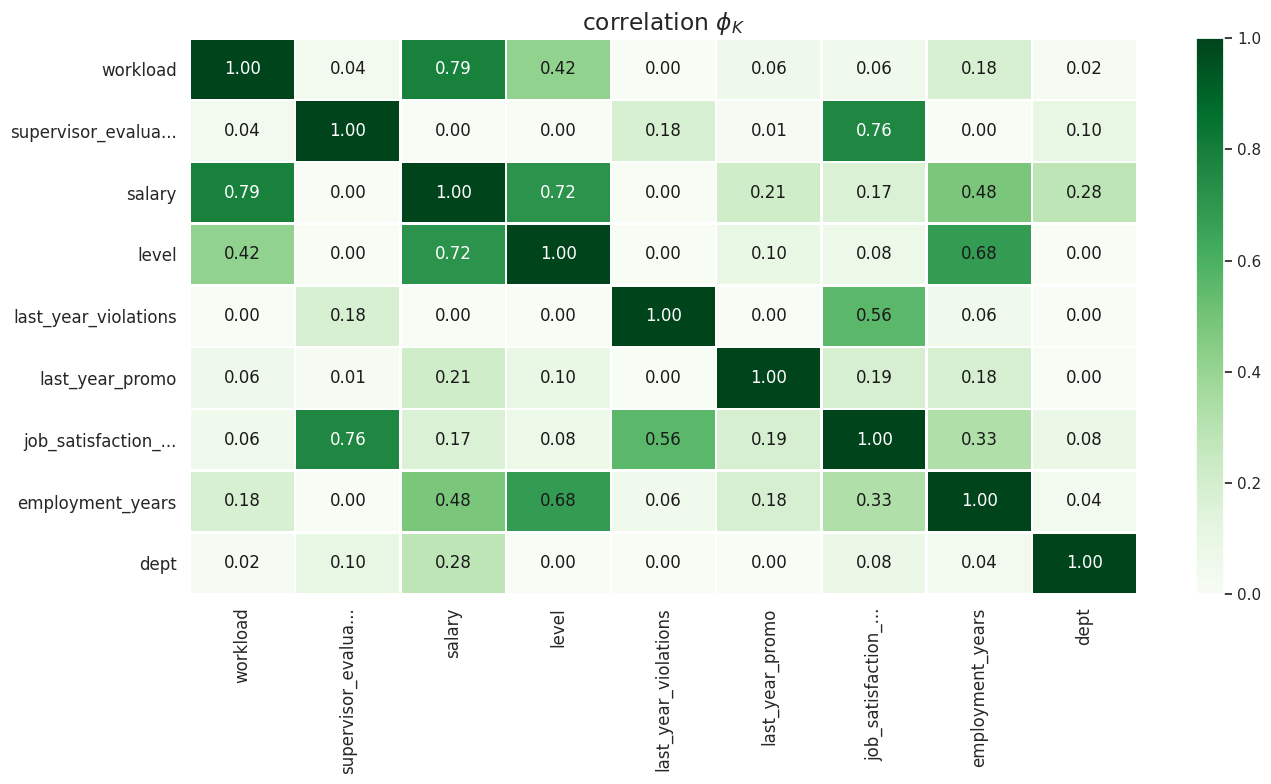

In [58]:
interval_cols = df_train_job_satisfaction_rate.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_train_job_satisfaction_rate[df_train_job_satisfaction_rate.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)


Фик матрица показала следующие корреляционные соотношения между параметрами:
- workload и salary - это объясняется тем, что большая нагрузка на сотрудника обычно сопровождается ростом его зарплаты
- salary и level - чем выше Level сотрудника тем выше его зарплата
- supervisor_evaluation и job_satisfaction_rate - чем выше оценка супервизора - тем выше его уровень удовлетворенности работой
- level и employment_years - level сотрудника зависит от количества проработанных лет

В целом корреляционная матрица не показала каких либо исключительных ситуаций - все более менее объяснимо. Есть корреляция между некоторыми входными параметрами и целевым - не не для всех входных параметров.

### Подготовка данных

Делаем merge двух датафреймов df_test_features и df_test_target_job_satisfaction_rate для формирования тестового датафрейма df_test_all, который будет содержать входные и целевой тестовые признаки. Объединение выполняем как LEFT JOIN по общей колонке id, так как у правого датафрейма строк больше так как мы ранее удаляли NaN у левого датафрейма.

In [59]:
df_test_all  = df_test_features.merge(df_test_target_job_satisfaction_rate, left_on='id', right_on='id', how='left')
display(df_test_all.head())
df_test_features.info()
df_test_all.info()
df_test_target_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1995 non-null   int64 
 1   dept                   1995 non-null   string
 2   level                  1995 non-null   string
 3   workload               1995 non-null   string
 4   employment_years       1995 non-null   string
 5   last_year_promo        1995 non-null   string
 6   last_year_violations   1995 non-null   string
 7   supervisor_evaluation  1995 non-null   string
 8   salary                 1995 non-null   int64 
dtypes: int64(2), string(7)
memory usage: 155.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1994
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1995 non-null   int64  
 1   dept          

 Далее формируем датафреймы X_train, X_test, y_train, y_test на основе датафреймов df_train_job_satisfaction_rate и df_test_all

In [60]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate','id'], axis=1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test_all.drop(['job_satisfaction_rate','id'], axis=1)
y_test = df_test_all['job_satisfaction_rate']

Далее формируем списки для скейлеров OneHotEncoder и MinMaxScaler и формируем ColumnTransformer для этих скейлеров для использования в пайплайне

In [61]:
ohe_columns = list(X_train.select_dtypes(exclude=np.number))
num_columns = list(X_train.select_dtypes(include=np.number))

print(ohe_columns)
print(num_columns)

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
['salary']


### Обучение моделей

In [62]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))/2)

smape_scorer = make_scorer(smape, greater_is_better=False)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
 
# Оцениваем качество на тестовой выборке
y_pred_test = best_model.predict(X_test)
smape_test = smape(y_test, y_pred_test)


print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', grid_search.best_score_)
print ("Метрика SMAPE лучшей модели на тестовой выборке:", smape_test)

,rank_test_score,param_models,mean_test_score,params
50,1,LinearRegression(),-4.210657,"{'models': LinearRegression(), 'preprocessor__num': 'passthrough'}"
49,2,LinearRegression(),-4.210657,"{'models': LinearRegression(), 'preprocessor__num': MinMaxScaler()}"
48,3,LinearRegression(),-4.210657,"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}"
47,4,DecisionTreeRegressor(random_state=42),-6.161231,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'preprocessor__num': 'passthrough'}"
46,4,DecisionTreeRegressor(random_state=42),-6.161231,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'preprocessor__num': MinMaxScaler()}"
45,4,DecisionTreeRegressor(random_state=42),-6.161231,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'preprocessor__num': StandardScaler()}"
33,7,DecisionTreeRegressor(random_state=42),-6.334354,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__max_features': 5, 'preprocessor__num': StandardScaler()}"
34,7,DecisionTreeRegressor(random_state=42),-6.334354,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__max_features': 5, 'preprocessor__num': MinMaxScaler()}"
35,9,DecisionTreeRegressor(random_state=42),-6.335076,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 4, 'models__max_features': 5, 'preprocessor__num': 'passthrough'}"
23,10,DecisionTreeRegressor(random_state=42),-6.373445,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 3, 'models__max_features': 5, 'preprocessor__num': 'passthrough'}"


Метрика SMAPE: 4.093318084461969
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'level', 'workload',
                                                   'employment_years',
                                                   'last_year_promo',
                                                   'last_year_violations',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['salary'])])),
      

### Выводы

Лучший результат показала модель LinearRegression (при выборе из вариантов LinearRegression и DecisionTreeRegressor) со значением метрики SMAPE = -4.21. Данная модель была проверена на тестовой выборке с значением метрики = -4.09


## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [63]:
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
display(df_train_quit.head(5))
df_train_quit.info()


df_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
display(df_test_target_quit.head(5))
df_test_target_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Предобработка данных

Значений категорий равных NaN или пробел в датафреймах df_train_quit и df_test_target_quit не обнаружено.
Исправлена грамматическая ошибка для значения категории *sinior* на *senior* для колонки df_train_quit['level']

In [64]:
display(df_train_quit['dept'].value_counts())
display(df_train_quit['level'].value_counts())
display(df_train_quit['workload'].value_counts())
display(df_train_quit['last_year_promo'].value_counts())
display(df_train_quit['last_year_violations'].value_counts())
display(df_train_quit['quit'].value_counts())
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')
display(df_train_quit['level'].value_counts())


sales         1438
technology    928 
purchasing    588 
marketing     582 
hr            464 
Name: dept, dtype: int64

junior    1949
middle    1694
sinior    357 
Name: level, dtype: int64

medium    2118
low       1208
high      674 
Name: workload, dtype: int64

no     3887
yes    113 
Name: last_year_promo, dtype: int64

no     3455
yes    545 
Name: last_year_violations, dtype: int64

no     2872
yes    1128
Name: quit, dtype: int64

junior    1949
middle    1694
senior    357 
Name: level, dtype: int64

Изменен тип всех колонок с object на string для датафреймов df_train_quit и df_test_target_quit

In [65]:
df_train_quit_str_col_list = df_train_quit.select_dtypes(exclude=np.number).columns
df_train_quit[df_train_quit_str_col_list] = \
  df_train_quit[df_train_quit_str_col_list].astype('string')
df_train_quit.info()

df_test_target_quit_str_col_list = df_test_target_quit.select_dtypes(exclude=np.number).columns
df_test_target_quit[df_test_target_quit_str_col_list] = \
  df_test_target_quit[df_test_target_quit_str_col_list].astype('string')
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   string
 2   level                  4000 non-null   string
 3   workload               4000 non-null   string
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   string
 6   last_year_violations   4000 non-null   string
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   string
dtypes: int64(4), string(6)
memory usage: 312.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    200

Колонки employment_years и supervisor_evaluation для df_train_quit датафрейма надо перевести в категориальный формат, так как их значения представляют собой целые числа и они занимают отоносительно небольшой диапазон

In [66]:
df_train_quit[['employment_years', 'supervisor_evaluation']] = \
  df_train_quit[['employment_years', 'supervisor_evaluation']].astype('string')
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   string
 2   level                  4000 non-null   string
 3   workload               4000 non-null   string
 4   employment_years       4000 non-null   string
 5   last_year_promo        4000 non-null   string
 6   last_year_violations   4000 non-null   string
 7   supervisor_evaluation  4000 non-null   string
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   string
dtypes: int64(2), string(8)
memory usage: 312.6 KB


### Исследовательский анализ данных

#### Построение гистограмм, boxplots и корреляционной матрицы

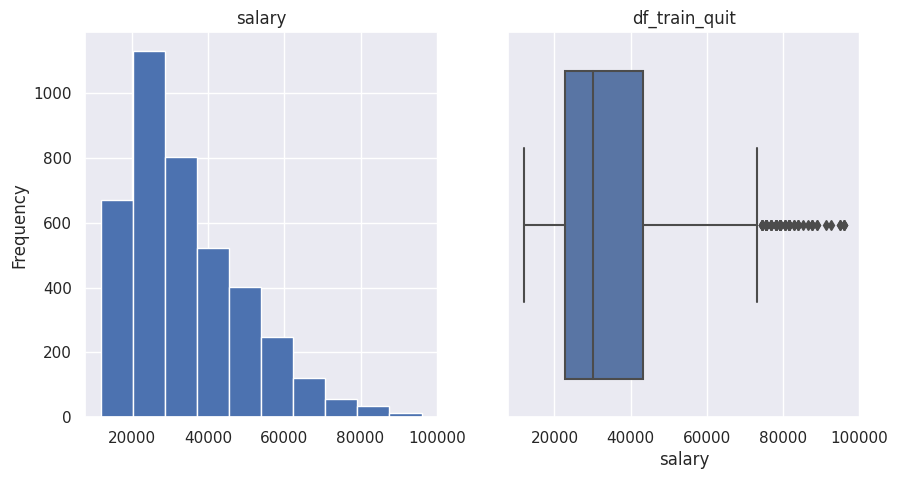

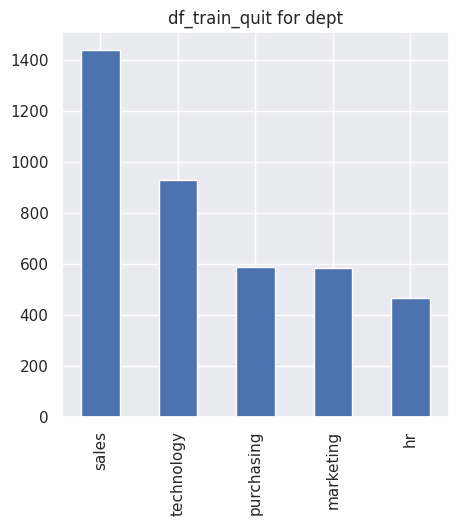

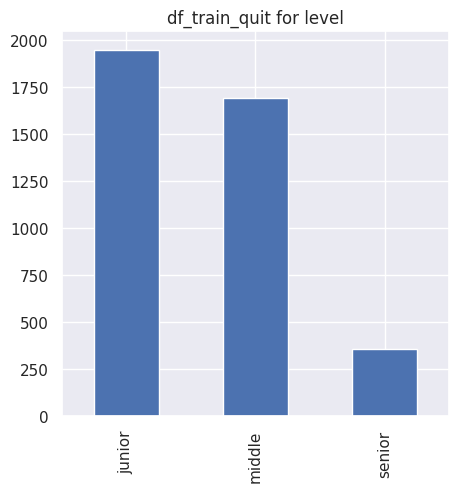

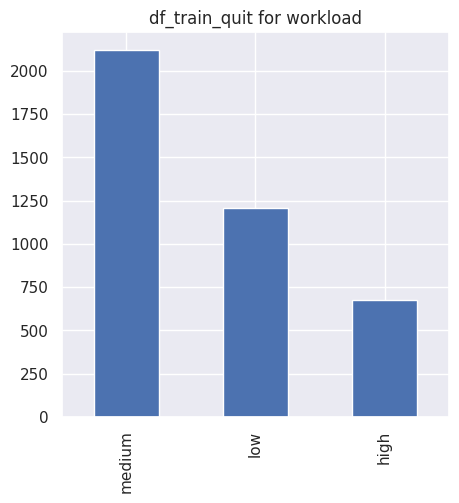

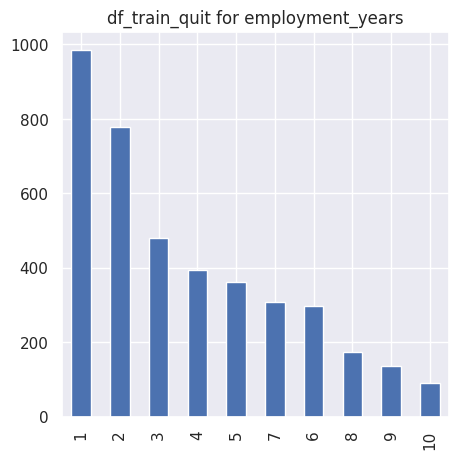

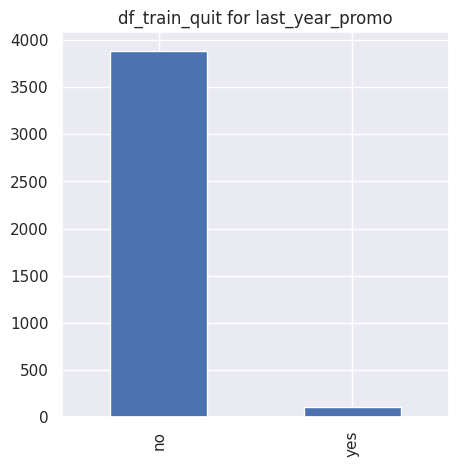

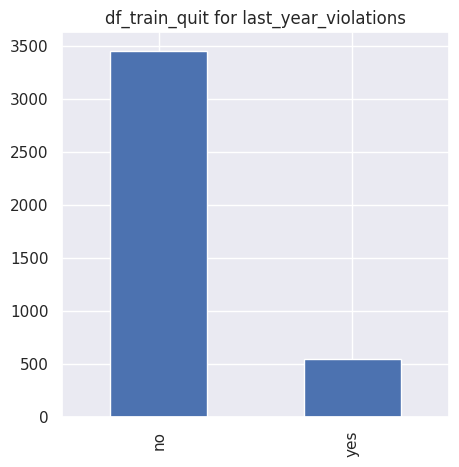

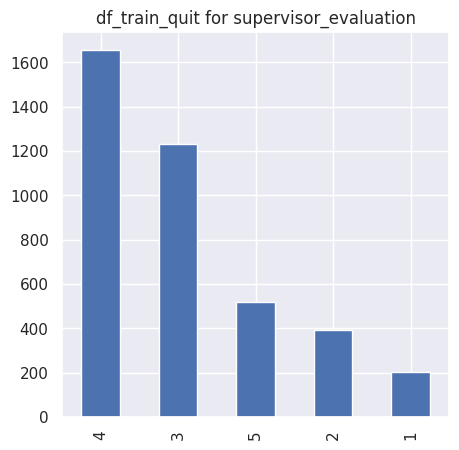

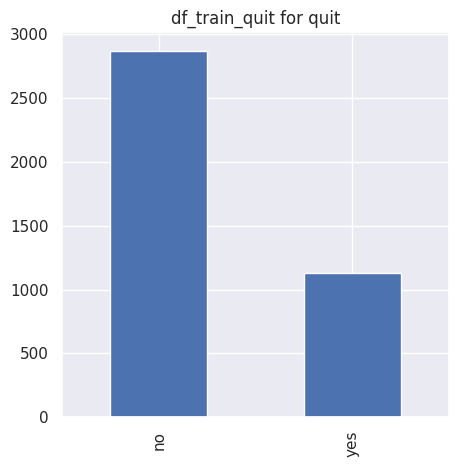

,dept,employment_years,last_year_promo,last_year_violations,level,quit,salary,supervisor_evaluation,workload
dept,1.000000,0.000000,0.000000,0.044274,0.000000,0.000000,0.280300,0.042772,0.000000
employment_years,0.000000,1.000000,0.156494,0.000000,0.692676,0.659093,0.491915,0.000000,0.213013
last_year_promo,0.000000,0.156494,1.000000,0.000000,0.110585,0.157370,0.215043,0.032376,0.044388
last_year_violations,0.044274,0.000000,0.000000,1.000000,0.000000,0.185071,0.086087,0.179228,0.014063
level,0.000000,0.692676,0.110585,0.000000,1.000000,0.312799,0.745104,0.007189,0.479480
quit,0.000000,0.659093,0.157370,0.185071,0.312799,1.000000,0.564154,0.245489,0.132243
salary,0.280300,0.491915,0.215043,0.086087,0.745104,0.564154,1.000000,0.055330,0.793876
supervisor_evaluation,0.042772,0.000000,0.032376,0.179228,0.007189,0.245489,0.055330,1.000000,0.000000
workload,0.000000,0.213013,0.044388,0.014063,0.479480,0.132243,0.793876,0.000000,1.000000


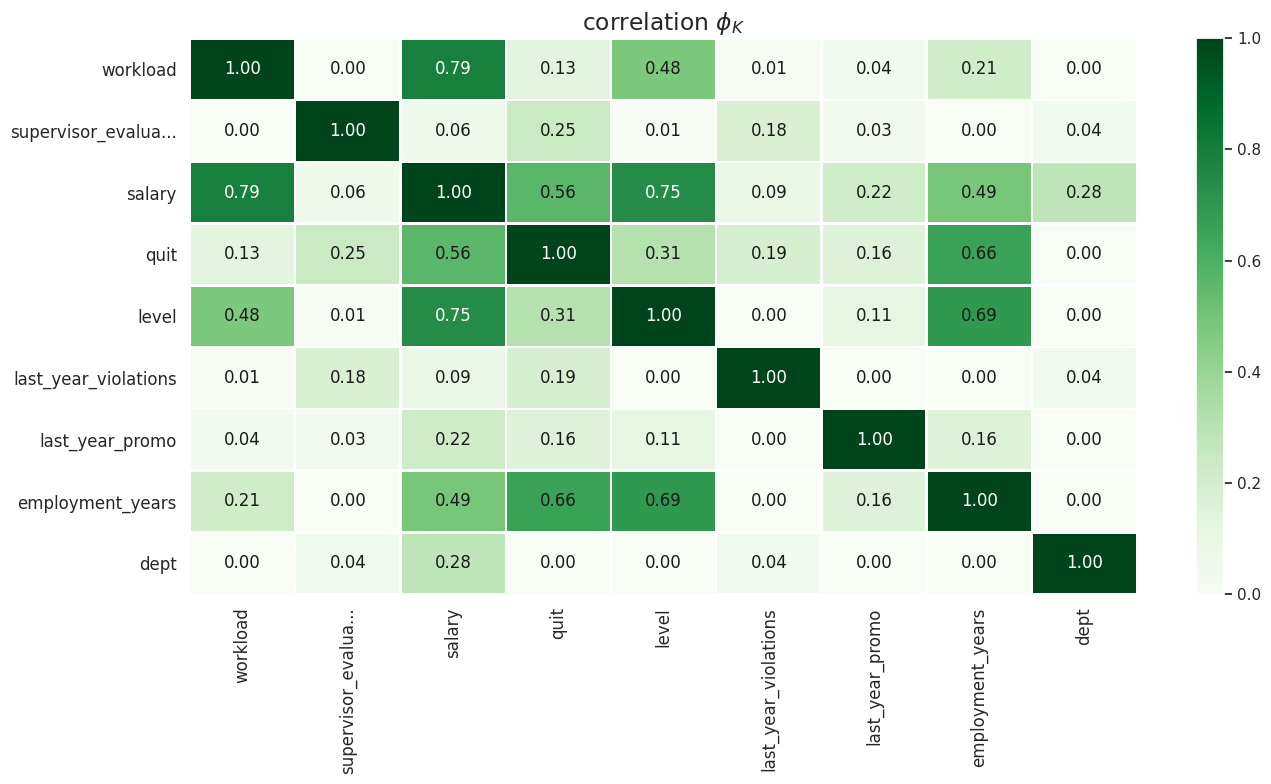

In [67]:
plot_sub_plot_hist_boxplot(df_train_quit.select_dtypes(include=np.number), 'df_train_quit')
plot_bar_plot_for_columns(df_train_quit.select_dtypes(exclude=np.number), 'df_train_quit')

interval_cols = df_train_quit.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_train_quit[df_train_quit.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

Анализ гистограмм, boxplots, bar диаграмм и корреляционной матрицы не показал отличий от результатов анализа для Задачи 1, произведенного ранее.

#### Составление портрета «уволившегося сотрудника»

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
4,910140,marketing,junior,medium,2,no,no,5,25200,no
6,417070,technology,middle,medium,8,no,no,2,44400,no


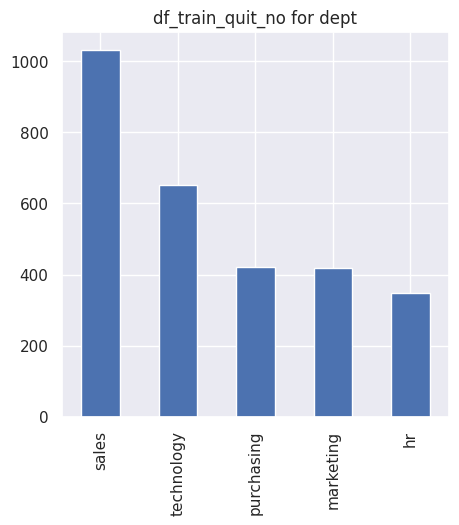

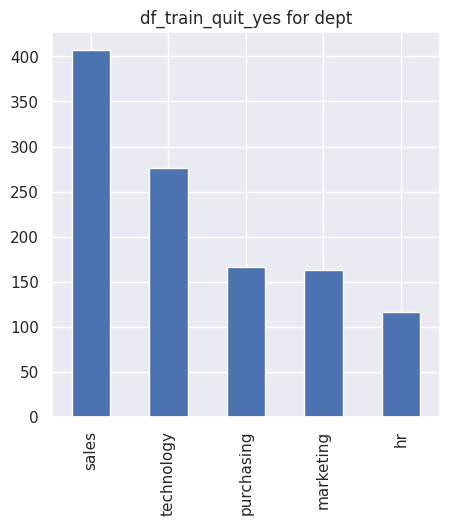

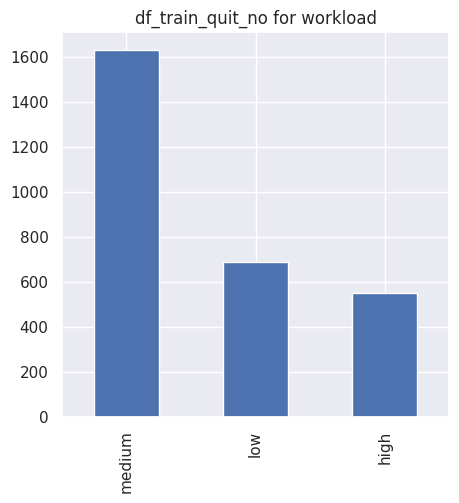

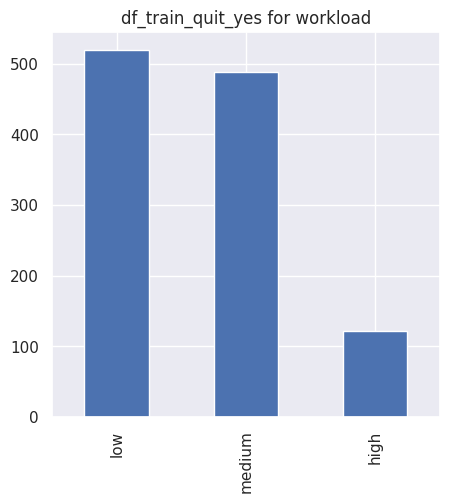

Mean salary for non-quit employees=37702.22841225627
Mean salary for quit employees=23885.106382978724


In [68]:
df_train_quit_yes = df_train_quit[df_train_quit['quit'] == 'yes']
df_train_quit_no = df_train_quit[df_train_quit['quit'] == 'no']
display(df_train_quit_no.head())

plot_bar_plot_for_columns(df_train_quit_no[['dept']], 'df_train_quit_no')
plot_bar_plot_for_columns(df_train_quit_yes[['dept']], 'df_train_quit_yes')

plot_bar_plot_for_columns(df_train_quit_no[['workload']], 'df_train_quit_no')
plot_bar_plot_for_columns(df_train_quit_yes[['workload']], 'df_train_quit_yes')

salary_mean_quit_no = df_train_quit_no['salary'].mean()
salary_mean_quit_yes = df_train_quit_yes['salary'].mean()

print(f'Mean salary for non-quit employees={salary_mean_quit_no}')
print(f'Mean salary for quit employees={salary_mean_quit_yes}')


Анализ датафреймов для действующих и уволившихся сотрудников показал, что:
- распределение по отделам для обоих сетов примерно одинаков и максимальное число сотрудников - в отделе sales
- распределение по нагрузке отличается для этих двух сетов - для действующих сотрудников максимальное количество имеет нагрузку medium, для уволившихся - нагрузку low
- сравнение средней зарплаты показало что средняя зарплата для уволившихся сотрудников ниже и равна 23885

#### Проверка утверждения что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

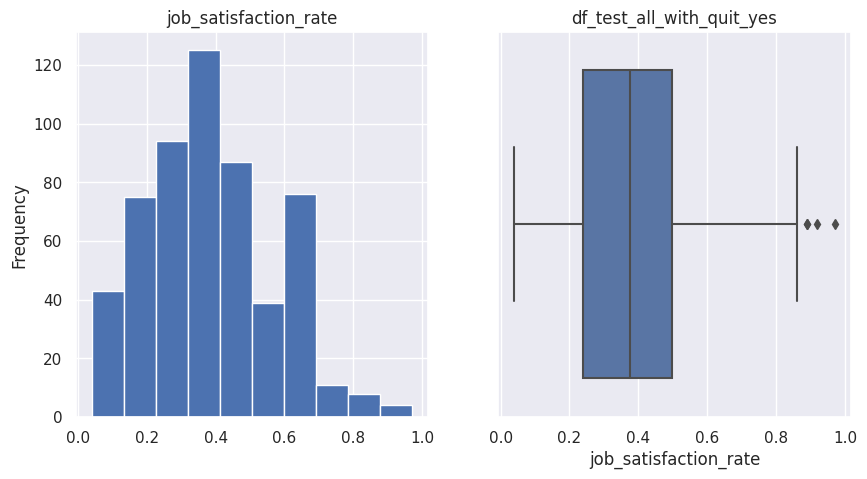

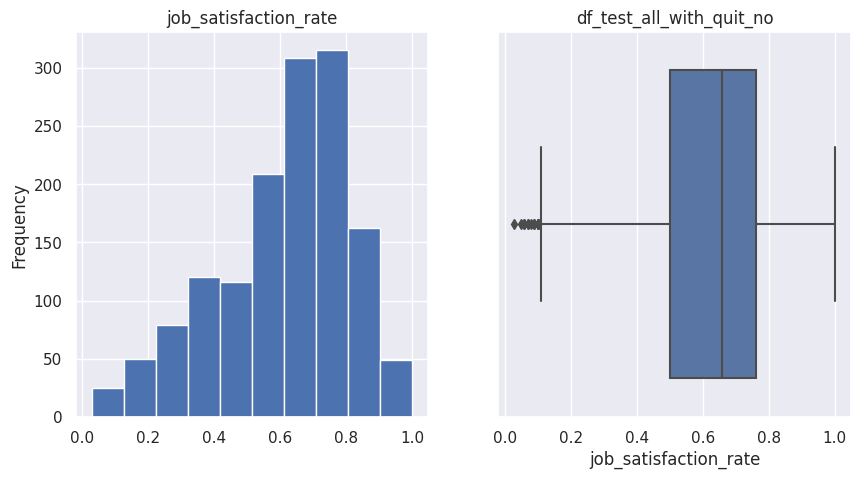

,dept,employment_years,job_satisfaction_rate,last_year_promo,last_year_violations,level,quit,salary,supervisor_evaluation,workload
dept,1.000000,0.000000,0.073968,0.000000,0.000000,0.000000,0.000000,0.329973,0.061348,0.032763
employment_years,0.000000,1.000000,0.311977,0.173551,0.066422,0.689777,0.605397,0.494455,0.000000,0.201814
job_satisfaction_rate,0.073968,0.311977,1.000000,0.336919,0.558690,0.095298,0.608237,0.169169,0.769379,0.050770
last_year_promo,0.000000,0.173551,0.336919,1.000000,0.000000,0.118225,0.137796,0.193685,0.012892,0.035671
last_year_violations,0.000000,0.066422,0.558690,0.000000,1.000000,0.017585,0.175451,0.000000,0.190324,0.000000
level,0.000000,0.689777,0.095298,0.118225,0.017585,1.000000,0.293919,0.748889,0.004687,0.474172
quit,0.000000,0.605397,0.608237,0.137796,0.175451,0.293919,1.000000,0.506767,0.293512,0.101692
salary,0.329973,0.494455,0.169169,0.193685,0.000000,0.748889,0.506767,1.000000,0.114893,0.785594
supervisor_evaluation,0.061348,0.000000,0.769379,0.012892,0.190324,0.004687,0.293512,0.114893,1.000000,0.039969
workload,0.032763,0.201814,0.050770,0.035671,0.000000,0.474172,0.101692,0.785594,0.039969,1.000000


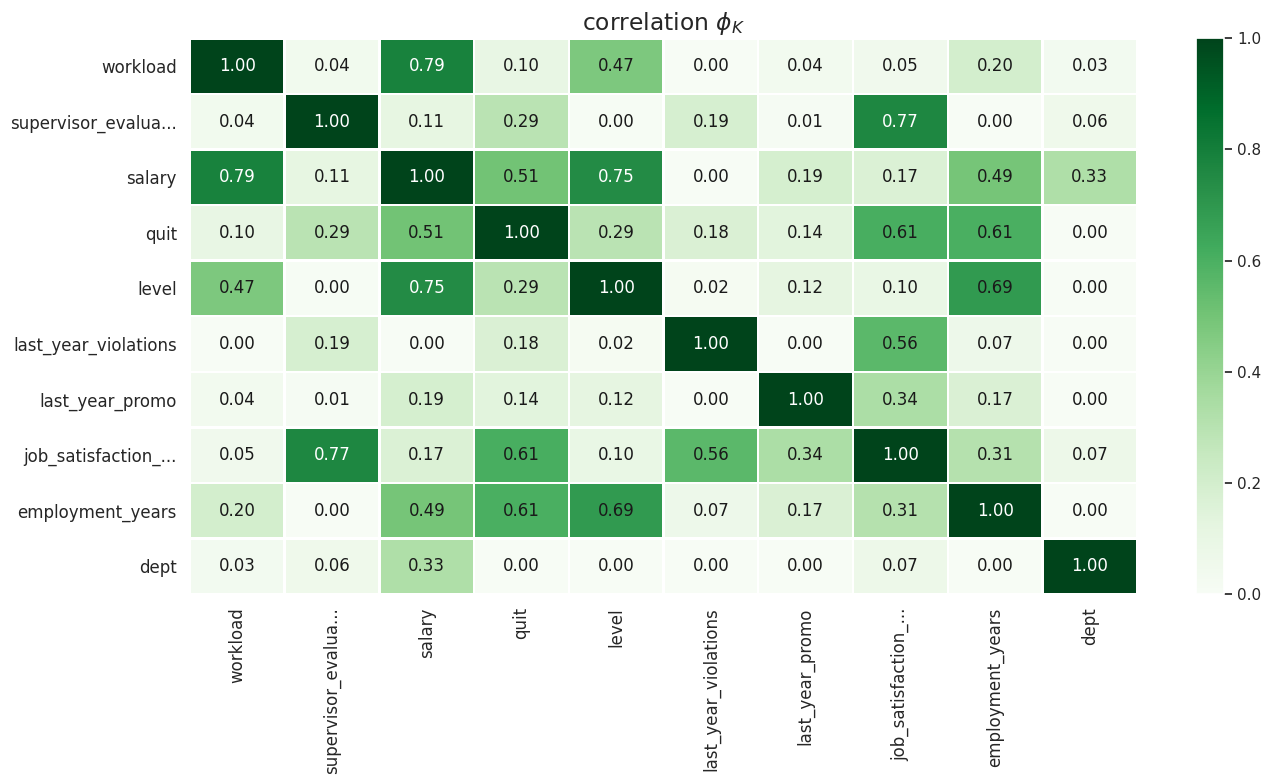

In [69]:
df_test_all_with_quit = df_test_all.merge(df_test_target_quit, left_on='id', right_on='id', how='left')
display(df_test_all_with_quit.isna().sum())
df_test_all_with_quit.head()
df_test_all_with_quit_yes = df_test_all_with_quit[df_test_all_with_quit['quit'] == 'yes']
df_test_all_with_quit_no = df_test_all_with_quit[df_test_all_with_quit['quit'] == 'no']

plot_sub_plot_hist_boxplot(df_test_all_with_quit_yes[['job_satisfaction_rate']], 'df_test_all_with_quit_yes')
plot_sub_plot_hist_boxplot(df_test_all_with_quit_no[['job_satisfaction_rate']], 'df_test_all_with_quit_no')

interval_cols = df_test_all_with_quit.select_dtypes(include=np.number).columns.difference(['id'])
phik_overview = phik_matrix(df_test_all_with_quit[df_test_all_with_quit.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)

Проверка корреляции между признаком job_satisfaction_rate и признаком того, уволился сотрудник или нет, показала, что:
- для уволившихся сотрудников медиана распределения признака job_satisfaction_rate смещена в сторону меньших значений и находится на уровне 0.3 - по сравнению с значением 0.8 для действующих сотрудников
- для обоих распределений есть некоторое количество выбросов - у уволившихся сотрудников выбросы в стороне больших значений, у действующих - в стороне меньших
- коэффициент корреляции между признаками job_satisfaction_rate и quit равен 0.61 - я не считаю значение этого коэффициента достаточным для того, чтобы считать эти признаки коррелируемыми

### Добавление нового входного признака

Новый входной признак не был добавлен, так как предыдущий анализ не показал достаточной корреляции между признаками job_satisfaction_rate и quit

### Подготовка данных

Формируем датафреймы X_train, X_test, y_train, y_test на основе датафреймов df_train_quit и df_test_all_with_quit

In [70]:
X_train = df_train_quit.drop(['quit','id'], axis=1)
y_train = df_train_quit['quit']
X_test = df_test_all_with_quit.drop(['job_satisfaction_rate','id', 'quit'], axis=1)
y_test = df_test_all_with_quit['quit']

Далее формируем списки для скейлеров OneHotEncoder и MinMaxScaler и формируем ColumnTransformer для этих скейлеров для использования в пайплайне

In [71]:
ohe_columns = list(X_train.select_dtypes(exclude=np.number))
num_columns = list(X_train.select_dtypes(include=np.number))

print(ohe_columns)
print(num_columns)

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
['salary']


### Обучение моделей

Обучаем на трех моделях с вариацией гиперпараметров для каждой модели:
- DecisionTreeClassifier
- LogisticRegression
- KNeighborsClassifier

In [81]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

custom_scorer = make_scorer(roc_auc_score, greater_is_better=True,  needs_threshold = True)

param_grid = [
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
 
print ('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
print ('Метрика roc_auc_score лучшей модели на тренировочной выборке:', grid_search.best_score_)

# Оцениваем качество на тестовой выборке
#y_pred_test = best_model.predict(X_test)

y_pred = best_model.predict_proba(X_test)[:,1]
roc_auc_score_test = roc_auc_score(y_test, y_pred)
# Выводим значение roc_auc_score на тестовой выборке
print ("Метрика roc_auc_score лучшей модели на тестовой выборке:", roc_auc_score_test)

,rank_test_score,param_models,mean_test_score,params
60,1,"LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear')",0.934725,"{'models': LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 6, 'preprocessor__num': StandardScaler()}"
57,2,"LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear')",0.934717,"{'models': LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 5, 'preprocessor__num': StandardScaler()}"
54,3,"LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear')",0.934676,"{'models': LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4, 'preprocessor__num': StandardScaler()}"
51,4,"LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear')",0.934628,"{'models': LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 3, 'preprocessor__num': StandardScaler()}"
61,5,"LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear')",0.934620,"{'models': LogisticRegression(C=6, penalty='l1', random_state=42, solver='liblinear'), 'models__C': 6, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...,...
13,61,DecisionTreeClassifier(random_state=42),0.714697,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}"
14,61,DecisionTreeClassifier(random_state=42),0.714697,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}"
2,64,DecisionTreeClassifier(random_state=42),0.646519,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}"
1,64,DecisionTreeClassifier(random_state=42),0.646519,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}"


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'level', 'workload',
                                                   'employment_years',
                                                   'last_year_promo',
                                                   'last_year_violations',
                                                   'supervisor_evaluation']),
                                                 ('num', StandardScaler(),
                                                  ['salary'])])),
                ('models',
         

### Выводы

Лучший результат показала модель LogisticRegression (при выборе из вариантов DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression) со значением метрики roc_auc_score = 0.9347251609474265. Данная модель была проверена на тестовой выборке с значением метрики = 0.9261932138484577


## Общие выводы 

### Описание задачи

На основании данных о сотрудниках организации необходимо построить две модели:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Кроме того, необходимо описать портрет «уволившегося сотрудника» - то есть указать признаки, характерные для таких сотрудников.

### Описание этапов работы

- Загрузка данных - загрузка данных из CSV файлов в датафреймы
- Предобработка данных - проверка данных на пропуски, дубликаты, опечатки
- Исследовательский анализ данных - построение гистограмм, boxplots, bar-диаграмм, корреляционых матриц
- Подготовка данных - merge датафреймов в один, формирование ColumnTransformer для пайплайна
- Обучение моделей - формирование пайплайна из ColumnTransformer и необходимого набора моделей, запуск пайплайна, определение лучшей модели через кросс-валидацию для данной метрики, проверка выбранной метрики на тестовых данных

### Выводы и дополнительные предложения для бизнеса

Построены две модели, которые уверенно предсказывают целевые параметры *job_satisfaction_rate* и *quit* для данных по сотрудникам организации.
Анализ данных показал, что параметр *job_satisfaction_rate* ниже для сотрудников, которые уже уволились, по сравнению с действующими сотрудниками. Кроме того, средняя заработная плата для уволившихся сотрудников ниже, чем для действующих и нагрузка для уволившихся сотрудников в большей степени находится в диапазоне ['low', 'medium']. Отсюда следуют следующие рекомендации для бизнеса для предотвращения увольнения сотрудников из организации:
- повышать заработную плату сотрудникам - с переводом уровня нагрузки в 'high'
- стремиться к увеличения параметра *job_satisfaction_rate*